In [ ]:
# function ConnectButton(){
#     console.log("Connect pushed"); 
#     document.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
! nvidia-smi

Sat Oct 15 13:18:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
% cd drive/MyDrive/lab

UsageError: Line magic function `%` not found.


In [1]:
! pip install tensorflow-addons
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm import tqdm
from sklearn.utils import class_weight


import keras
from keras import Input
from keras.models import Model
from keras.utils import *
from keras.layers import *


import matplotlib.pyplot as plt

import gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 21.0 MB/s 


In [2]:
os.chdir(r"/content/drive/MyDrive/lab")
print(os.getcwd())

/content/drive/MyDrive/lab


In [3]:
'''
    Config
'''
# IMG_SIZE = 224
# IMG_SIZE = 240
IMG_SIZE = 260
# IMG_SIZE = 300

In [4]:

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def load_ben_color(image, sigmaX=10):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = crop_image_from_gray(image).astype('uint8')
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
  return image
'''
    Preprocessing for ImageDataGenerator since ImageDataGenerator reads images in rgb mode, while opencv in bgr
'''
def preprocessing(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image).astype('uint8')
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [5]:
df = pd.read_csv('train.csv')
id_code = df['id_code']

In [6]:
# 讀取所有 train 圖片 and 
mypath=r'train_images' 
# mypath=r'resize_train_image' 
# read all file in address
# join() mean is path address
onlyfiles = [ f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath,f))]
image = list(range(len(onlyfiles)))

for n in range(len(onlyfiles)): 
    img = cv2.imread('train_images/{}.png'.format(id_code[n]))
    img = load_ben_color(img)
    image[n] = img

In [7]:
x_train = np.array(image)
x_train = x_train.reshape(x_train.shape[0], IMG_SIZE, IMG_SIZE, 3) 
x_train = x_train.astype('uint8')
x_train.shape

(3662, 260, 260, 3)

In [8]:
y_train = df.diagnosis.values 
y_train = to_categorical(y_train) 
y_train.shape

(3662, 5)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42 , stratify = df.diagnosis.values )

In [10]:
print(np.unique(df.diagnosis.values , return_counts=True))
print(np.sum(np.unique(df.diagnosis.values , return_counts=True)))

(array([0, 1, 2, 3, 4]), array([1805,  370,  999,  193,  295]))
3672


In [11]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    fill_mode='constant',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True)
    #preprocessing_function=preprocessing)

In [13]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(df.diagnosis.values),y = df.diagnosis.values)
class_weights = dict(enumerate(class_weights))

In [ ]:
# y_integers = []
# for label in y_train:
#     for e in range(len(label)):
#         if label[e] == 1:
#             y_integers.append(e)

# class_weights = class_weight.compute_class_weight('balanced',np.unique(y_integers),y_integers)

In [12]:
base_model = tf.keras.applications.EfficientNetB2(include_top=False,weights="imagenet",input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = True

31790344/31790344 [==============================] - 2s 0us/step


In [20]:
l2_lambda=0.05
Dropout_rate = 0.5
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer_1 = tf.keras.layers.Dense(1024, activation='relu') # kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
Dropout_1 = tf.keras.layers.Dropout(Dropout_rate)
dense_layer_2 = tf.keras.layers.Dense(512, activation='relu')
Dropout_2 = tf.keras.layers.Dropout(Dropout_rate)
dense_layer_3 = tf.keras.layers.Dense(256, activation='relu')
Dropout_3 = tf.keras.layers.Dropout(Dropout_rate)
dense_layer_4 = tf.keras.layers.Dense(128, activation='relu')
Dropout_4 = tf.keras.layers.Dropout(Dropout_rate)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')


model = tf.keras.models.Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      Dropout_1,
      dense_layer_2,
      Dropout_2,
      dense_layer_3,
      Dropout_3,
      dense_layer_4,
      Dropout_4,
      prediction_layer
  ])

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tfa.losses.SigmoidFocalCrossEntropy(gamma=3,reduction=tf.keras.losses.Reduction.AUTO), # reduction=tf.keras.losses.Reduction.AUTO
              metrics = [tfa.metrics.CohenKappa(num_classes = 5, sparse_labels=False),'accuracy'])


In [16]:
# mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=1, min_lr=0.00005)

In [18]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = 'best_model',
save_weights_only=True,
monitor='val_cohen_kappa',
mode='max',
save_best_only=True,
verbose=1)

In [22]:
# history = model.fit(x_train,y_train ,epochs=30,batch_size=32,validation_split = 0.2)

history = model.fit(datagen.flow(x_train, y_train, batch_size=16),validation_data=(x_val, y_val),
                   steps_per_epoch=(len(x_train)/16), epochs=100,callbacks=[rl,model_checkpoint_callback],class_weight=class_weights)

Epoch 1/100
172/171 [==============================] - ETA: 0s - loss: 0.2127 - cohen_kappa: 0.2029 - accuracy: 0.4206
Epoch 1: val_cohen_kappa improved from 0.29514 to 0.37857, saving model to best_model
171/171 [==============================] - 82s 404ms/step - loss: 0.2127 - cohen_kappa: 0.2029 - accuracy: 0.4206 - val_loss: 0.1247 - val_cohen_kappa: 0.3786 - val_accuracy: 0.5895 - lr: 1.0000e-04
Epoch 2/100
172/171 [==============================] - ETA: 0s - loss: 0.1872 - cohen_kappa: 0.3062 - accuracy: 0.5044
Epoch 2: val_cohen_kappa improved from 0.37857 to 0.43601, saving model to best_model
171/171 [==============================] - 67s 390ms/step - loss: 0.1872 - cohen_kappa: 0.3062 - accuracy: 0.5044 - val_loss: 0.1130 - val_cohen_kappa: 0.4360 - val_accuracy: 0.6070 - lr: 1.0000e-04
Epoch 3/100
172/171 [==============================] - ETA: 0s - loss: 0.1720 - cohen_kappa: 0.3672 - accuracy: 0.5495
Epoch 3: val_cohen_kappa improved from 0.43601 to 0.48926, saving model t

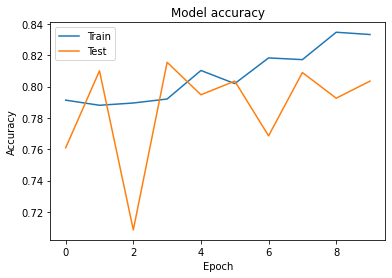

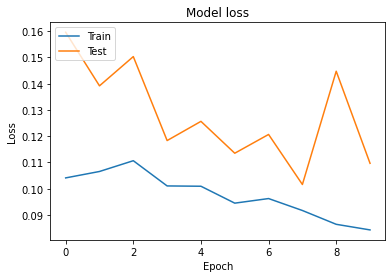

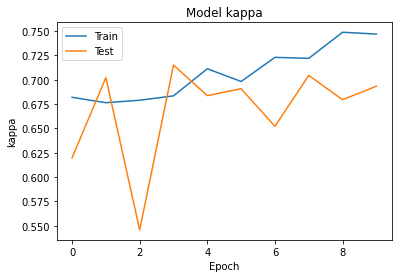

In [ ]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['cohen_kappa'])
plt.plot(history.history['val_cohen_kappa'])
plt.title('Model kappa')
plt.ylabel('kappa')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('eff_b2_model')

In [ ]:
# model.save_weights('eff_b0_model.h5')

In [ ]:
model = keras.models.load_model('eff_b2_model')

In [ ]:
# model.load_weights('my_model_weights.h5')

In [ ]:
np.save('my_history.npy',history.history)

In [ ]:
# history=np.load('my_history.npy',allow_pickle='TRUE').item()

## prediction on testset

In [ ]:
test_csv = pd.read_csv('sample_submission.csv')
id_code = test_csv['id_code']
test_prediction = np.empty(len(id_code), dtype='float32')
for i in range(len(id_code)):
    img = cv2.imread('test_images/{}.png'.format(id_code[i]))
    img = load_ben_color(img)
    X = np.array([img])
    pred = model.predict(X)
    test_prediction[i] = np.argmax(pred).astype('int64')

## Submission 

In [ ]:
# prediction = predict(test_prediction).astype('uint8')
test_csv['diagnosis'] = test_prediction
test_csv.to_csv("submission.csv", index=False)
unique, counts = np.unique(test_prediction, return_counts=True)
tmp = dict(zip(unique, counts))
print(tmp)
print('Done!')

{0.0: 401, 1.0: 290, 2.0: 867, 3.0: 260, 4.0: 110}
Done!
